In [1]:
from time import time

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as Tdata
import torch.nn.functional as F
import torch.distributions as TD

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

# in order to install: pip install POT
import ot

import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 3
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# dgm_utils
from dgm_utils import train_model, show_samples, visualize_images
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data

def reset_seed():
    OUTPUT_SEED = 0xBADBEEF
    torch.manual_seed(OUTPUT_SEED)
    np.random.seed(OUTPUT_SEED)

reset_seed()

# <center>Deep Generative Models</center>
## <center>Seminar 9</center>

<center><img src="pics/mipt_logo.png" width=600 /></center>
<center>28.02.2023</center>

## Plan

1. Forwar KL vs Reverse KL vs JSD. 
    
    - Mode collapse

2. Vanilla GAN on 1D and 2D multimodal data

3. $1$-Wasserstein distance
    
    - Discrete $1$-Wasserstein distance
    
    - Continuous $1$-Wasserstein distance

# Forward KL vs Reverse KL vs JSD

In [5]:
X = torch.from_numpy(np.linspace(-6,6,500)).double()

In [6]:
single_gaussian = TD.Normal(torch.tensor(0.), torch.tensor(1.))

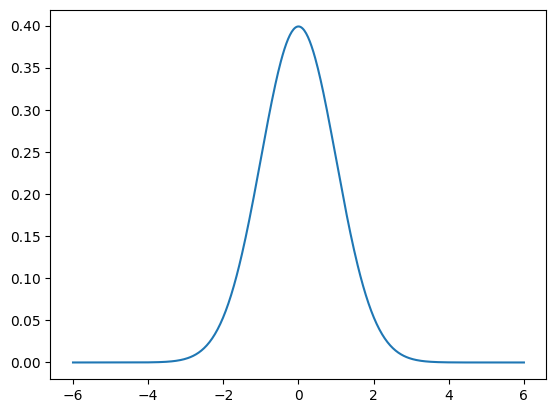

In [7]:
plt.plot(X.numpy(), single_gaussian.log_prob(X).exp().numpy())
plt.show()

In [8]:
# make mixture of gaussians with 
# means: (-2, 2)
# stds: (0.5, 0.5)
# mixture probabilities (0.8, 0.2)


pi = torch.tensor([0.8, 0.2])
mu = torch.tensor([-2., 2.])
scale = torch.tensor([0.5, 0.5])

mixture_gaussian = TD.MixtureSameFamily(TD.Categorical(pi), TD.Normal(mu, scale))

In [9]:
def plot_distributions(X, real_log_prob, model_log_prob=None, title=None, figsize=None, savepath=None):
    with torch.no_grad():
        res1 = real_log_prob(X).exp()
        if model_log_prob is not None:
            res2 = model_log_prob(X).exp()

    if figsize is None:
        figsize = (5, 5)
    plt.figure(figsize=figsize)    
    plt.plot(X.numpy(), res1.numpy(), color='b', linewidth=3, label=r'$\pi(\mathbf{x})$')
    plt.fill_between(X.numpy(), np.zeros_like(X.numpy()), res1.numpy(),  color='b', alpha=0.2)
    if model_log_prob is not None:
        plt.plot(X.numpy(), res2.numpy(), 'g', linewidth=3, label=r'$p(\mathbf{x} | \mu, \sigma)$')
        plt.fill_between(X.numpy(), np.zeros_like(X.numpy()), res2.numpy(),  color='g', alpha=0.2)
    if title is not None:
        plt.title(title, fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

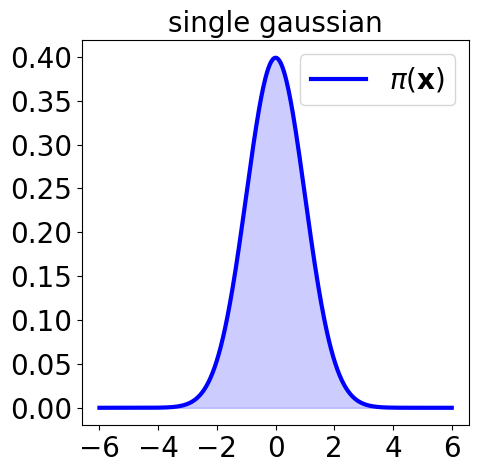

In [10]:
plot_distributions(X, single_gaussian.log_prob, title='single gaussian')

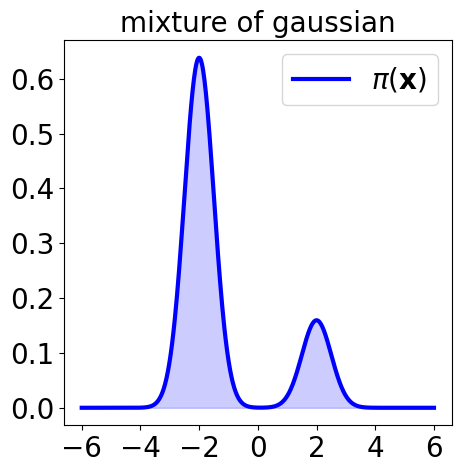

In [11]:
plot_distributions(X, mixture_gaussian.log_prob, title='mixture of gaussian')

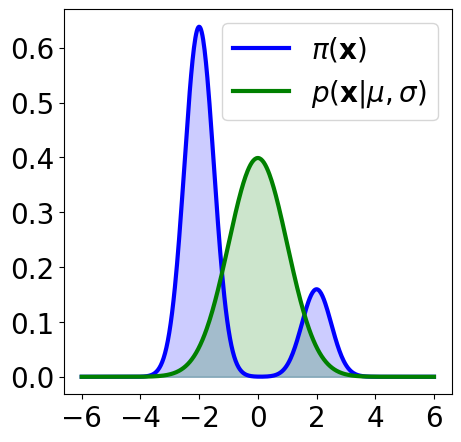

In [12]:
plot_distributions(X, mixture_gaussian.log_prob, single_gaussian.log_prob)

<img src="pics/kld_jsd.jpg" width=800 height=800 />

In [13]:
def KLD(X, log_prob1, log_prob2):
    # p and q return log pdf
    # X - some linspace
    return (log_prob1(X).exp() * (log_prob1(X) - log_prob2(X))).sum() * (X.max() - X.min()) / len(X)

In [14]:
def JSD(X, log_prob1, log_prob2):
    
    def log_prob_mean(x):
        prob_mean = (log_prob1(x).exp() + log_prob2(x).exp()) / 2
        return prob_mean.log()
    
    return (KLD(X, log_prob1, log_prob_mean) + KLD(X, log_prob2, log_prob_mean)) / 2

In [15]:
forward_KL_loss_fn = lambda X, real_log_prob, model_log_prob: KLD(X, real_log_prob, model_log_prob)
reverse_KL_loss_fn = lambda X, real_log_prob, model_log_prob: KLD(X, model_log_prob, real_log_prob)
JSD_loss_fn = lambda X, real_log_prob, model_log_prob: JSD(X, real_log_prob, model_log_prob)

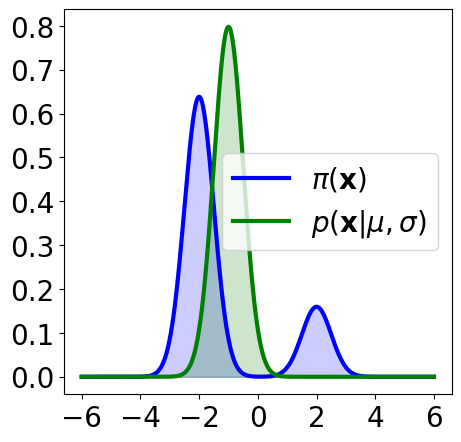

In [16]:
mu_start = -1
sigma_start = 0.5

# define trainable params
mu = torch.tensor(mu_start, requires_grad=True, dtype=torch.double)
sigma = torch.tensor(sigma_start, requires_grad=True, dtype=torch.double)
single_gaussian = TD.Normal(mu, sigma)

plot_distributions(X, mixture_gaussian.log_prob, single_gaussian.log_prob)

In [17]:
def solve_task(optimizer, loss_fn, real_log_prob, model_log_prob, n_iters):
    for it in range(n_iters):
        optimizer.zero_grad()

        loss = loss_fn(X, real_log_prob, model_log_prob)
        loss.backward()
        optimizer.step()

        if it % 5 == 0: 
            plot_distributions(X, mixture_gaussian.log_prob, single_gaussian.log_prob, title=f'step: {it}, loss: {loss:.2f}')

### Forward KL optimization

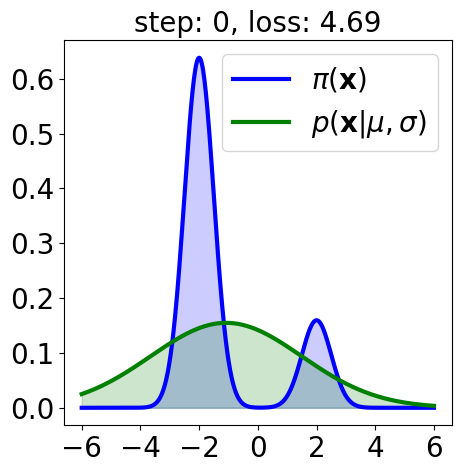

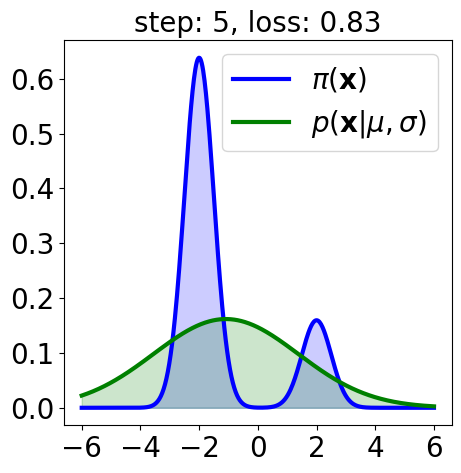

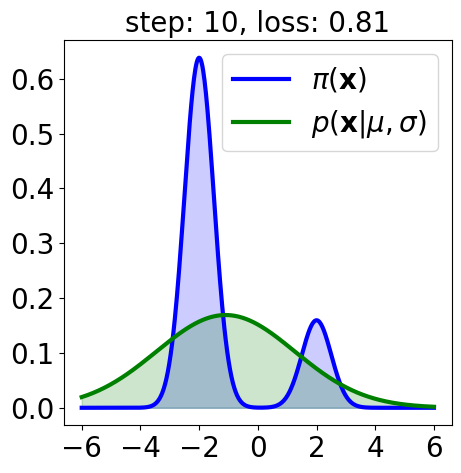

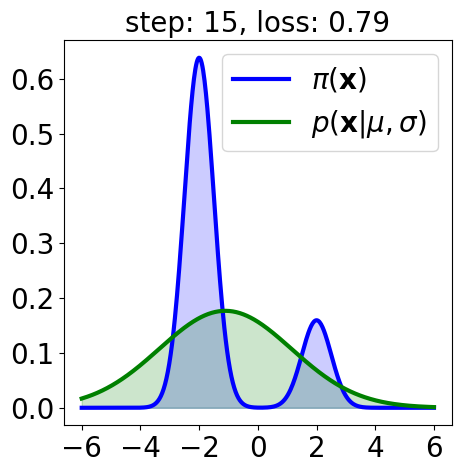

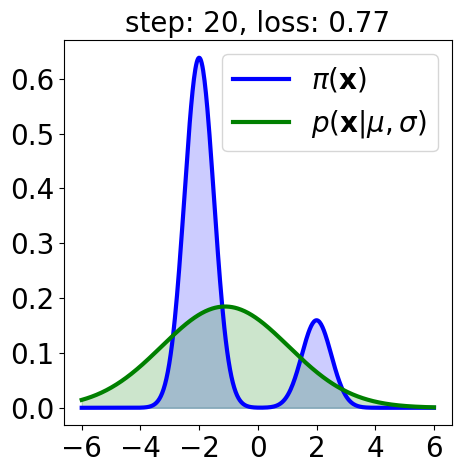

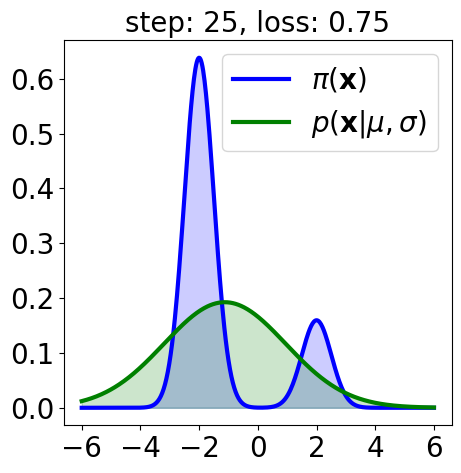

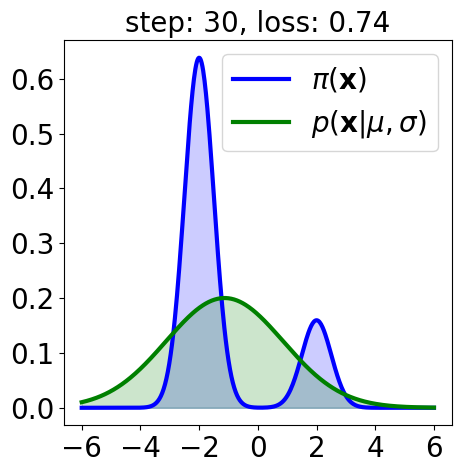

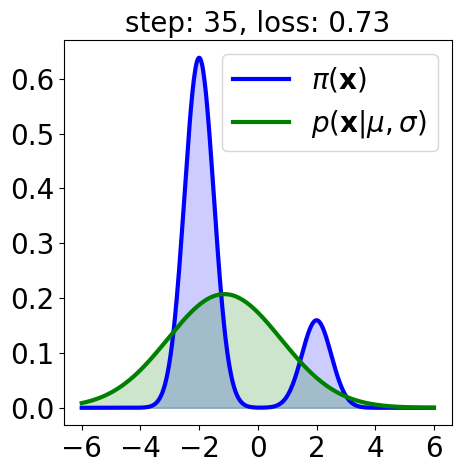

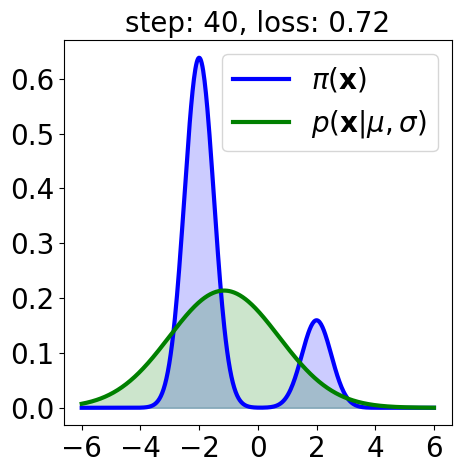

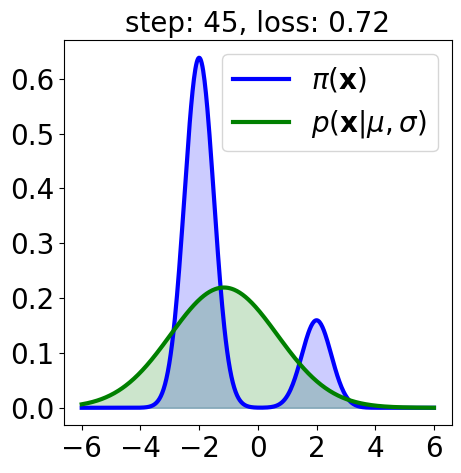

In [18]:
N_ITERS = 50
LEARNING_RATE = 0.1

mu_start = -1
sigma_start = 0.5

mu = torch.tensor(mu_start, requires_grad=True, dtype=torch.double)
sigma = torch.tensor(sigma_start, requires_grad=True, dtype=torch.double)
single_gaussian = TD.Normal(mu, sigma)

optimizer = torch.optim.SGD([mu, sigma], lr=LEARNING_RATE)

solve_task(optimizer, forward_KL_loss_fn, mixture_gaussian.log_prob, single_gaussian.log_prob, N_ITERS)

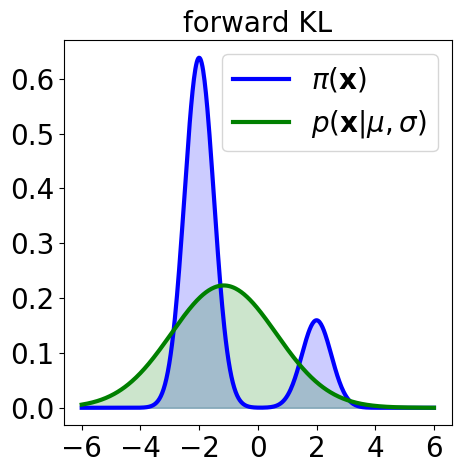

In [19]:
plot_distributions(
    X, 
    mixture_gaussian.log_prob, 
    single_gaussian.log_prob, 
    title='forward KL', 
    #savepath='forward_KL.png'
)

### Reverse KL optimization

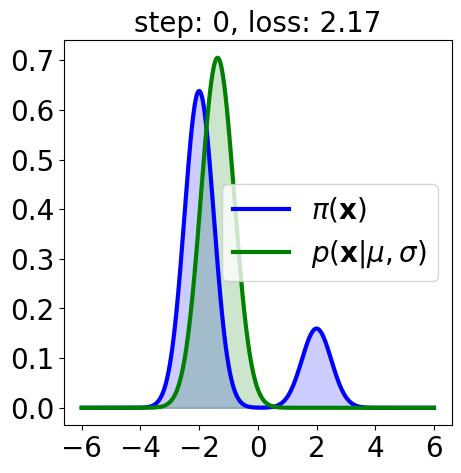

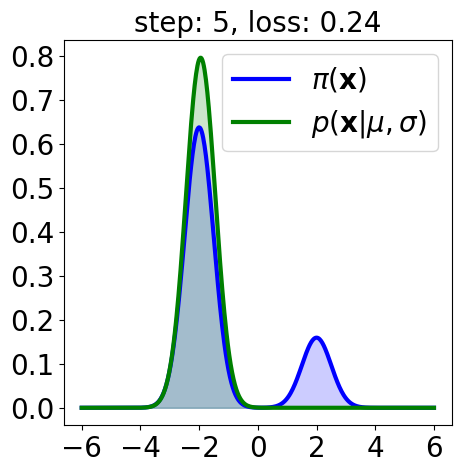

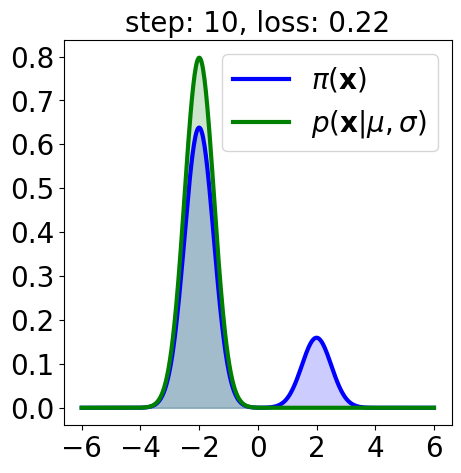

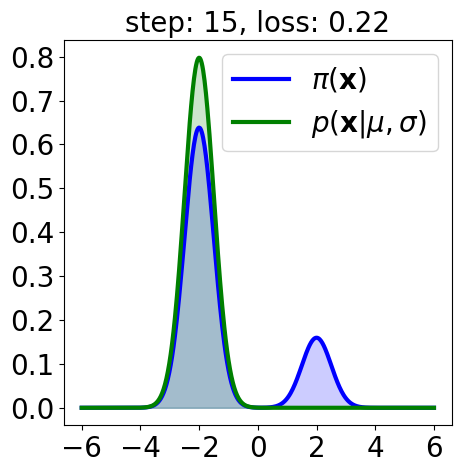

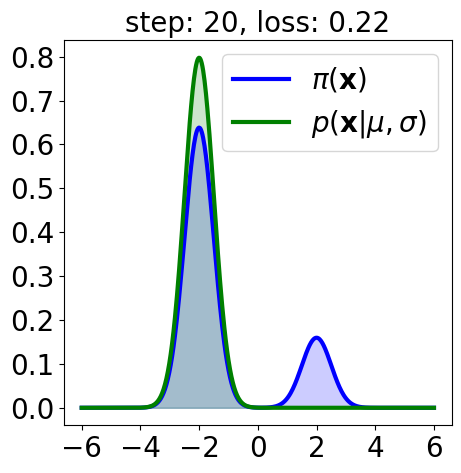

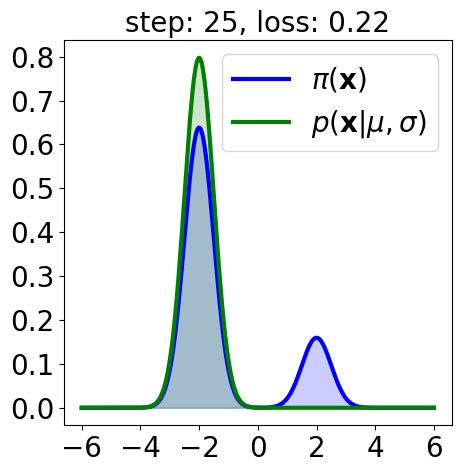

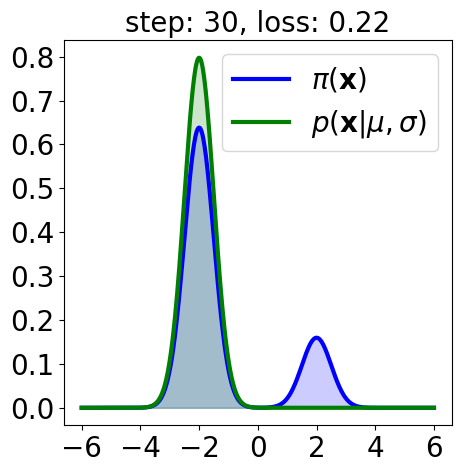

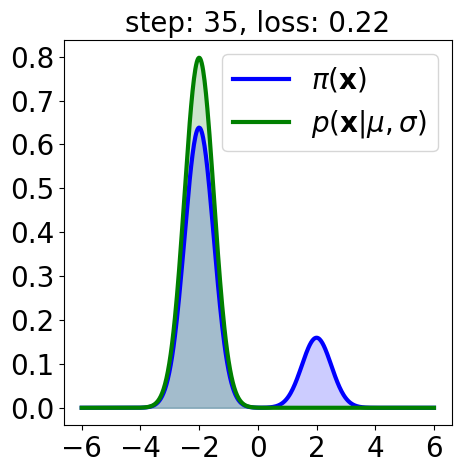

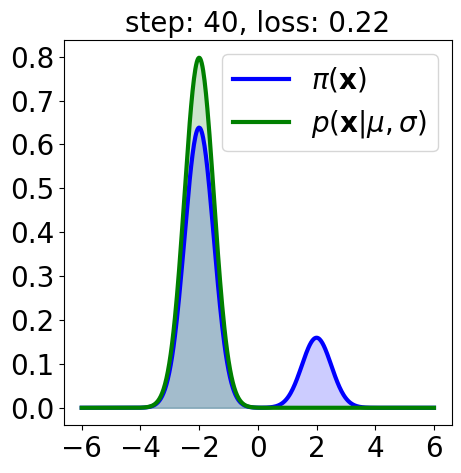

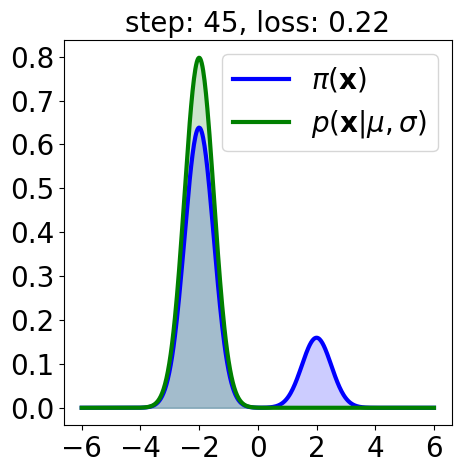

In [20]:
N_ITERS = 50
LEARNING_RATE = 0.1

mu_start = -1
sigma_start = 0.5

mu = torch.tensor(mu_start, requires_grad=True, dtype=torch.double)
sigma = torch.tensor(sigma_start, requires_grad=True, dtype=torch.double)
single_gaussian = TD.Normal(mu, sigma)

optimizer = torch.optim.SGD([mu, sigma], lr=LEARNING_RATE)

solve_task(optimizer, reverse_KL_loss_fn, mixture_gaussian.log_prob, single_gaussian.log_prob, N_ITERS)

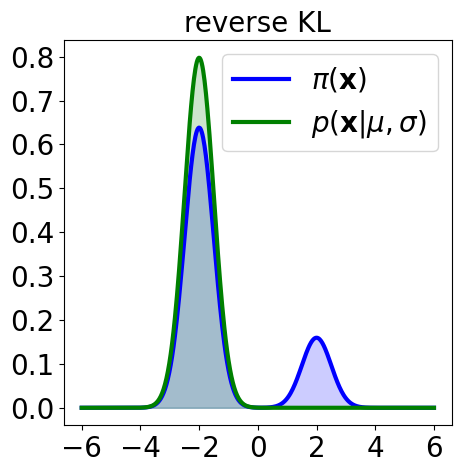

In [21]:
plot_distributions(
    X, 
    mixture_gaussian.log_prob, 
    single_gaussian.log_prob, 
    title='reverse KL', 
    #savepath='reverse_KL.png'
)

### Jensen Shannon optimization

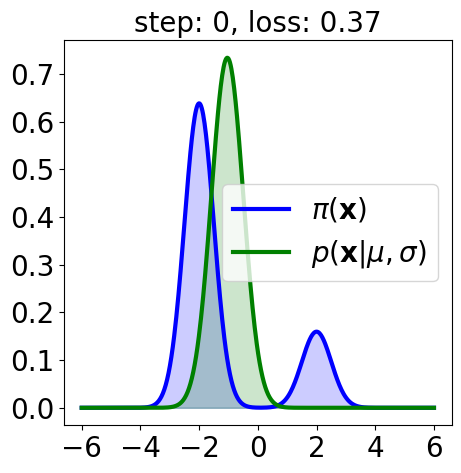

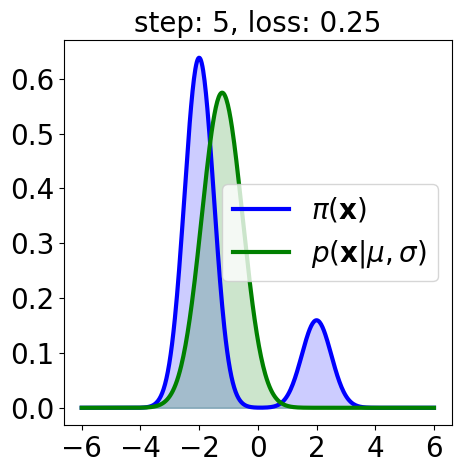

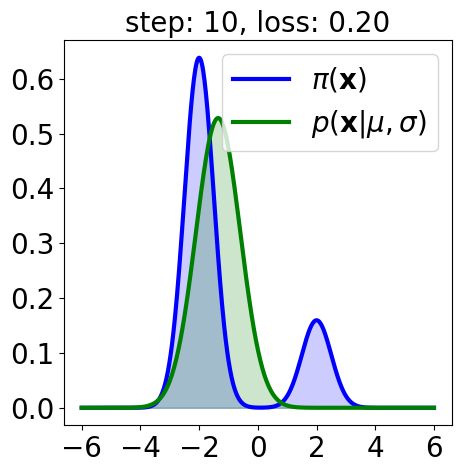

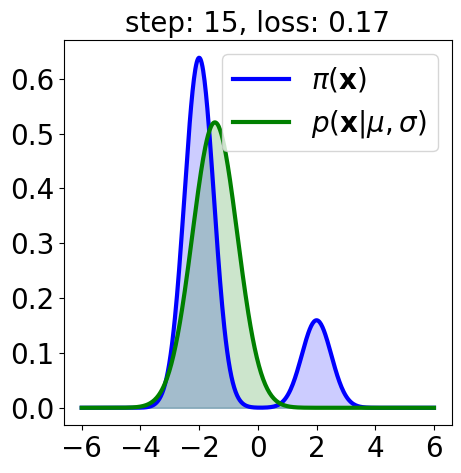

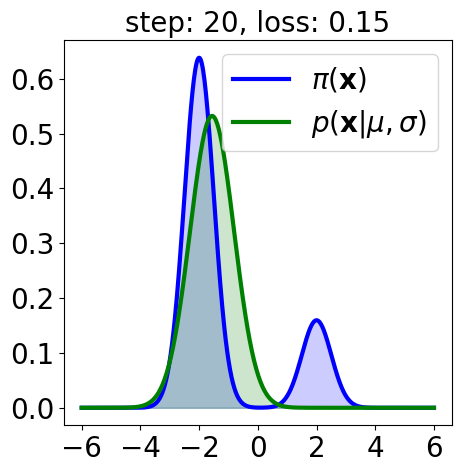

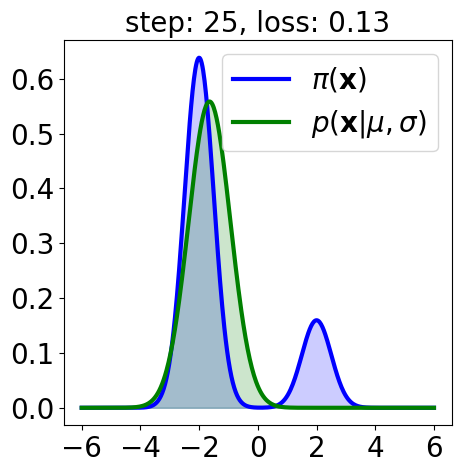

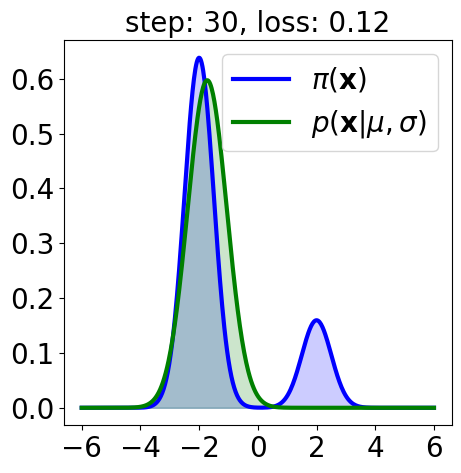

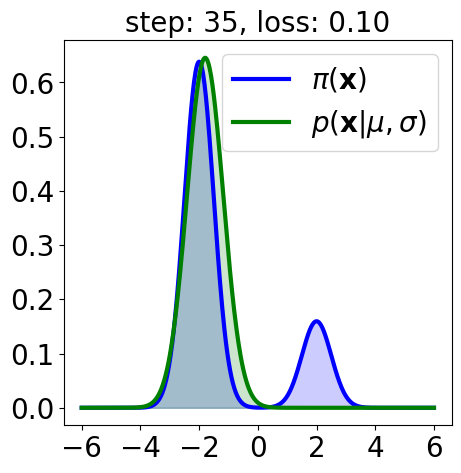

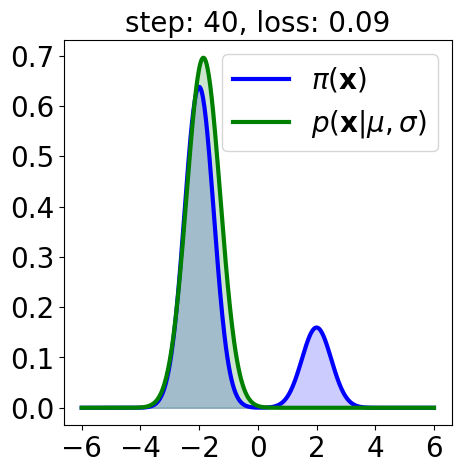

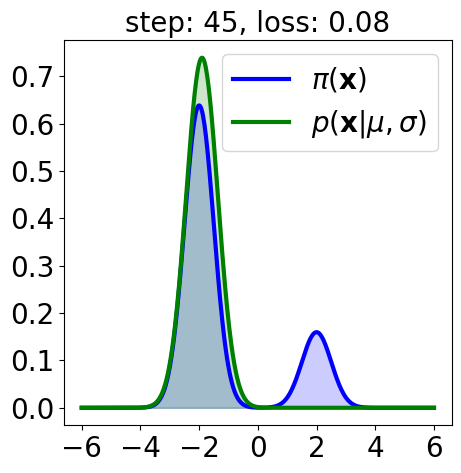

In [22]:
N_ITERS = 50
LEARNING_RATE = 0.1

mu_start = -1
sigma_start = 0.5

mu = torch.tensor(mu_start, requires_grad=True, dtype=torch.double)
sigma = torch.tensor(sigma_start, requires_grad=True, dtype=torch.double)
single_gaussian = TD.Normal(mu, sigma)

optimizer = torch.optim.SGD([mu, sigma], lr=LEARNING_RATE)

solve_task(optimizer, JSD_loss_fn, mixture_gaussian.log_prob, single_gaussian.log_prob, N_ITERS)

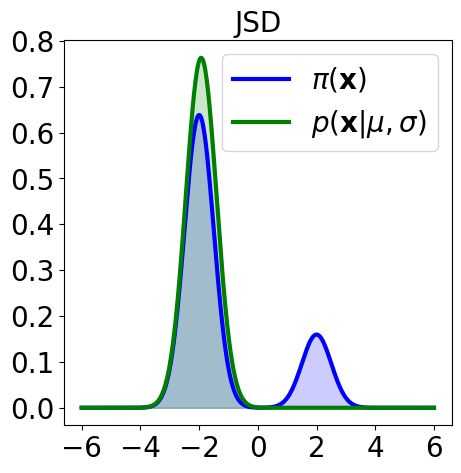

In [23]:
plot_distributions(
    X, 
    mixture_gaussian.log_prob, 
    single_gaussian.log_prob, 
    title='JSD', 
    #savepath='JSD.png'
)

# Vanilla GAN

<img src="pics/gan_objective.jpg" width=800 height=800 />

Helpful functions

In [28]:
def get_simple_model(hiddens):
    assert len(hiddens) > 1

    modules = []
    for in_, out_ in zip(hiddens[:-2], hiddens[1:-1]):
        modules.extend([nn.Linear(in_, out_), nn.ReLU()])

    modules.append(nn.Linear(hiddens[-2], hiddens[-1]))

    return nn.Sequential(*modules)

def plot_gan_data(data_fn, noise_fn, data_pdf=None):
    noise = noise_fn(5000).numpy().flatten()
    target = data_fn(5000).numpy().flatten()

    plt.hist(noise, label='noise', alpha=0.5, density=True, color='b')
    plt.hist(target, label='target', alpha=0.5, density=True, color='g')
    if data_pdf is not None:
        x = np.linspace(-6,6,100)
        plt.plot(x, data_pdf(x), 'g', label='real distibution')

    plt.legend(loc='upper left')
    plt.show()

def visualize_GAN(gan, data_pdf=None):
    size = 500
    x = np.linspace(-6,6,100)
    bins = np.linspace(-6,6,60)
    real_data = gan.data_fn(size)
    noise = gan.noise_fn(size)
    sampled_data = gan.generate_samples(noise)
    
    plt.hist(noise.numpy(), label='noise', alpha=0.5, density=True, color='b', bins=bins)
    plt.hist(real_data.numpy(), label='real data', alpha=0.5, density=True, color='g', bins=bins)
    plt.hist(sampled_data.numpy(), label='G samples', alpha=0.5, density=True, color='r', bins=bins)
    
    if data_pdf is not None:
        plt.plot(x, data_pdf(x), 'g', label='real distibution')
    with torch.no_grad():
        plt.plot(x, gan.D(torch.from_numpy(x).float().unsqueeze(-1)).numpy(), 'b', label='D distibution')
    
    plt.legend(loc='upper left')
    plt.show()

VanillaGAN 

In [29]:
class VanillaGAN():
    def __init__(self, G, D, noise_fn, data_fn,
                 batch_size=32, device='cpu', lr_D=1e-3, lr_G=2e-4):
        """A GAN class for holding and training a generator and discriminator
        Args:
            G: a Ganerator network
            D: A Discriminator network
            noise_fn: function f(num: int) -> pytorch tensor, (latent vectors)
            data_fn: function f(num: int) -> pytorch tensor, (real samples)
            batch_size: training batch size
            device: cpu or CUDA
            lr_D: learning rate for the discriminator
            lr_G: learning rate for the generator
        """
        self.G = G
        self.G = self.G.to(device)
        self.D = D
        self.D = self.D.to(device)
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.batch_size = batch_size
        self.device = device
        # !
        self.criterion = nn.BCELoss()
        self.optim_D = optim.Adam(D.parameters(),
                                  lr=lr_D, betas=(0.5, 0.999))
        self.optim_G = optim.Adam(G.parameters(),
                                  lr=lr_G, betas=(0.5, 0.999))
        # is needed in D train loop
        self.target_ones = torch.ones((batch_size, 1)).to(device)
        self.target_zeros = torch.zeros((batch_size, 1)).to(device)
    
    def generate_samples(self, latent_vec=None, num=None):
        """Sample from the generator.
        Args:
            latent_vec: A pytorch latent vector or None
            num: The number of samples to generate if latent_vec is None
        If latent_vec and num are None then us self.batch_size random latent
        vectors.
        ! We don't need grad for generated samples
        """
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        # your code here
        with torch.no_grad():
            samples = self.G(latent_vec)
        return samples

    def train_step_G(self):
        """Train the generator one step and return the loss."""
        self.G.zero_grad()
        latent_vec = self.noise_fn(self.batch_size)
        # your code here
        # use self.target_ones
        generated = self.G(latent_vec)
        classifications = self.D(generated)
        loss = self.criterion(classifications, self.target_ones)
        loss.backward()
        self.optim_G.step()
        return loss.item()

    def train_step_D(self):
        """Train the discriminator one step and return the losses."""
        self.D.zero_grad()

        # real samples
        real_samples = self.data_fn(self.batch_size)
        # calc real loss
        # you code here
        pred_real = self.D(real_samples)
        loss_real = self.criterion(pred_real, self.target_ones)

        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        # calc fake loss
        # you shouldn't optimize G here
        # you code here
        
        with torch.no_grad():
            fake_samples = self.G(latent_vec)
        pred_fake = self.D(fake_samples)
        loss_fake = self.criterion(pred_fake, self.target_zeros)

        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_D.step()
        
        return loss_real.item(), loss_fake.item()

    def train_step(self):
        """Train both networks and return the losses."""
        loss_D = self.train_step_D()
        loss_G = self.train_step_G()
        return loss_G, loss_D

Data

In [31]:
noise_fn = lambda x: torch.rand((x, 1), device='cpu') - 0.5

pi = torch.tensor([0.7, 0.3])
mu = torch.tensor([-3., 3.])
scale = torch.tensor([1., 1.])

mixture_gaussian = TD.MixtureSameFamily(TD.Categorical(pi), TD.Normal(mu, scale))

def data_fn(x):
    return mixture_gaussian.sample((x, 1))

def data_pdf(x):
    return mixture_gaussian.log_prob(torch.tensor(x)).exp().numpy()

In [35]:
gen_hiddens = [1, 64, 64, 64, 1]
dis_hiddens = [1, 64, 64, 64, 1]
G = get_simple_model(gen_hiddens)
D = nn.Sequential(*get_simple_model(dis_hiddens), nn.Sigmoid())

gan = VanillaGAN(G, D, noise_fn, data_fn, device='cpu')
loss_g, loss_d_real, loss_d_fake = [], [], []

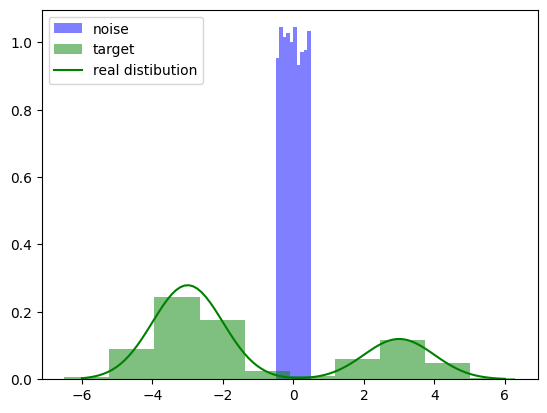

In [36]:
plot_gan_data(data_fn, noise_fn, data_pdf)

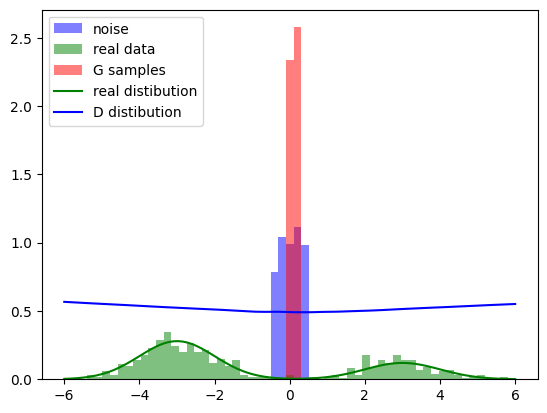

In [37]:
visualize_GAN(gan, data_pdf=data_pdf)

Training on multimodal data

In [38]:
epochs = 20
batches = 100

Epoch 1/20 (0s): G=1.431, Dr=0.278, Df=0.358


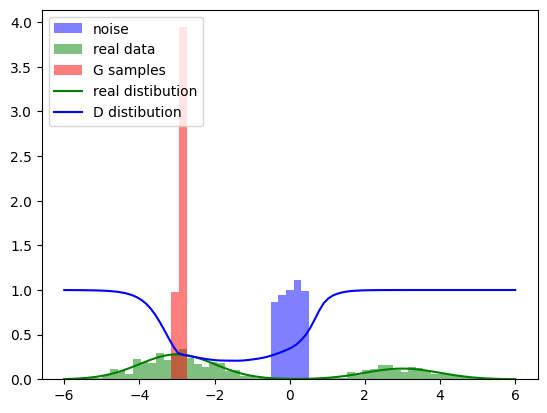

Epoch 2/20 (1s): G=1.226, Dr=0.524, Df=0.372


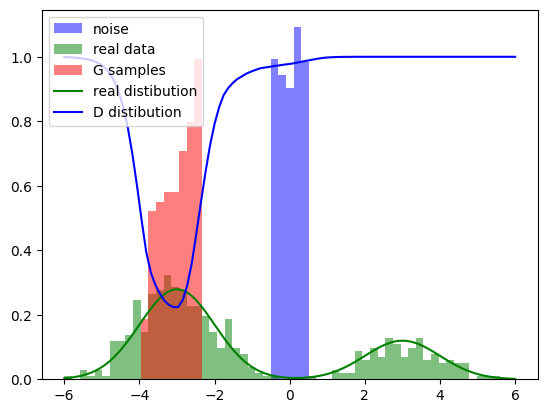

Epoch 3/20 (2s): G=1.034, Dr=0.584, Df=0.462


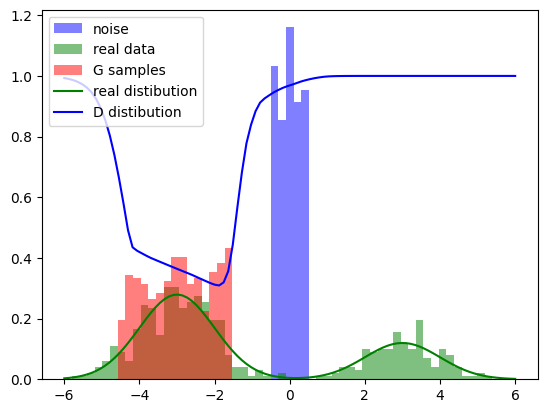

Epoch 4/20 (3s): G=0.920, Dr=0.618, Df=0.516


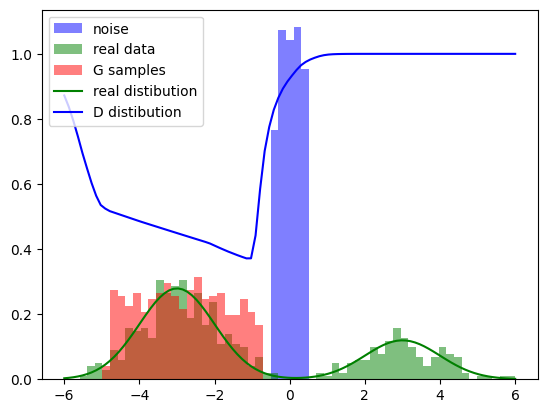

Epoch 5/20 (4s): G=0.917, Dr=0.611, Df=0.523


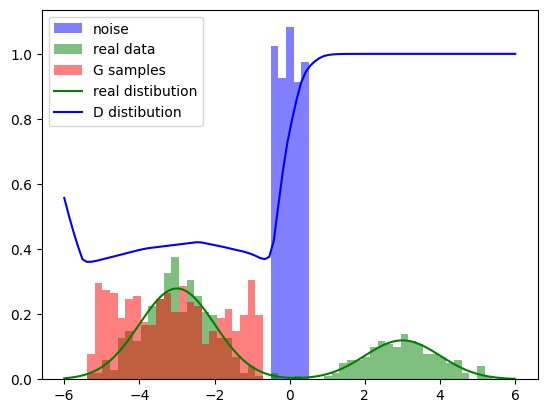

Epoch 6/20 (5s): G=0.913, Dr=0.611, Df=0.518


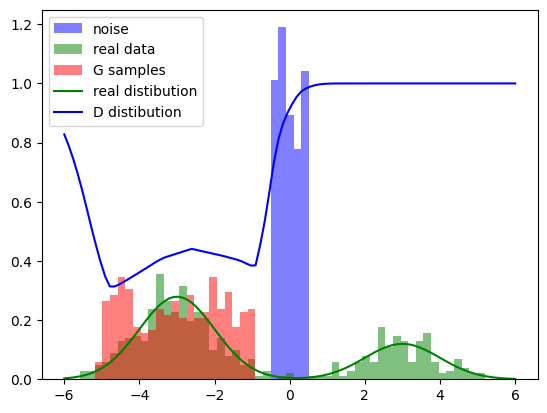

Epoch 7/20 (6s): G=0.919, Dr=0.602, Df=0.520


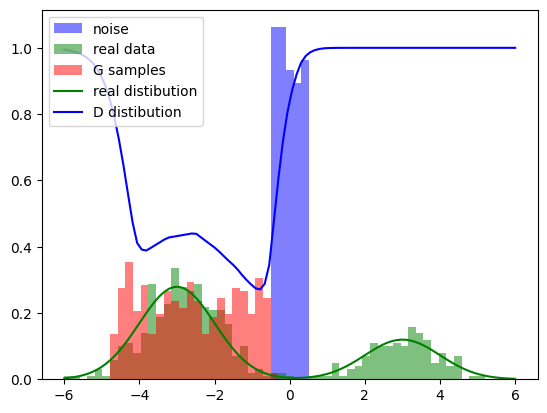

Epoch 8/20 (7s): G=0.926, Dr=0.614, Df=0.521


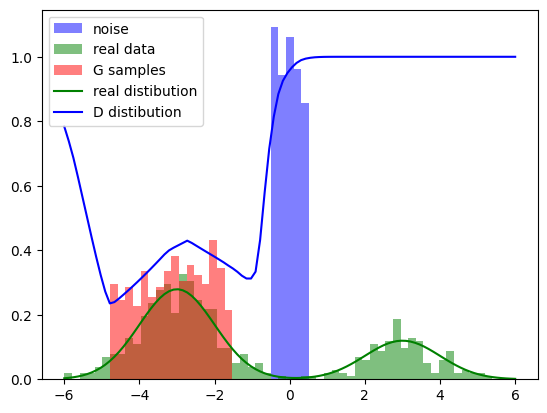

Epoch 9/20 (8s): G=0.920, Dr=0.607, Df=0.515


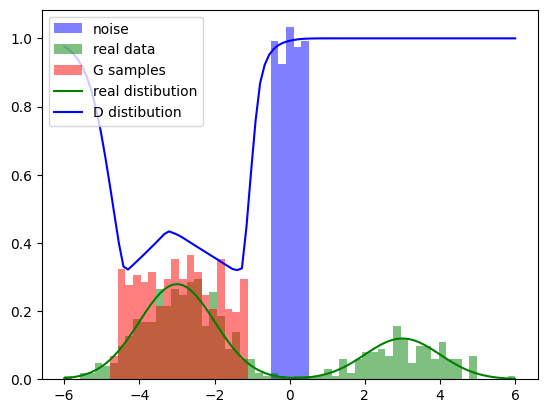

Epoch 10/20 (9s): G=0.933, Dr=0.600, Df=0.521


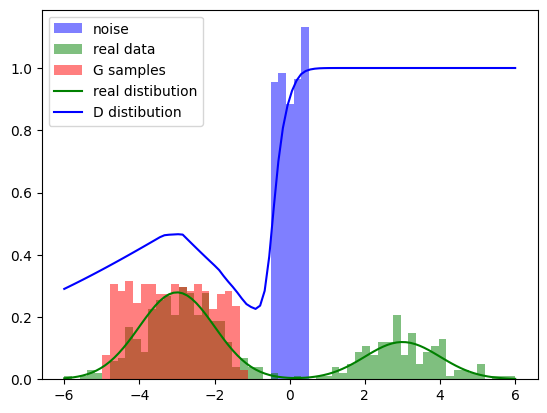

Epoch 11/20 (10s): G=0.914, Dr=0.618, Df=0.521


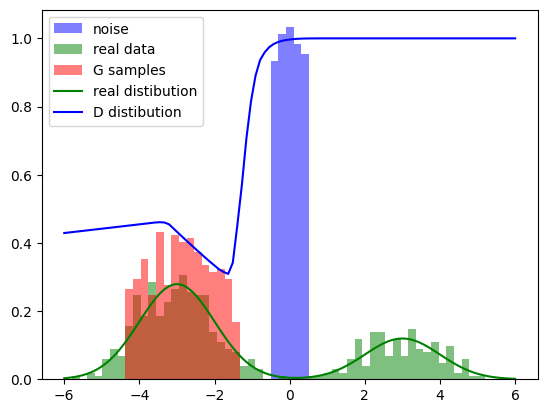

Epoch 12/20 (11s): G=0.915, Dr=0.615, Df=0.521


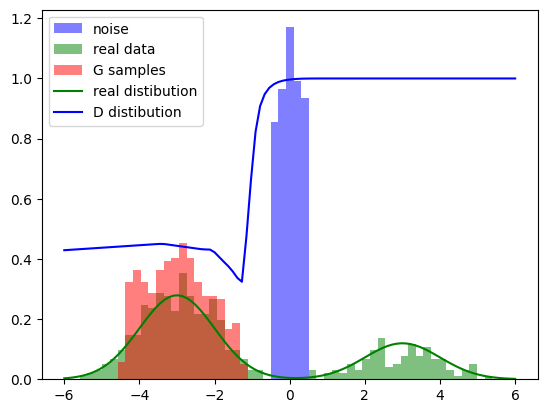

Epoch 13/20 (12s): G=0.916, Dr=0.604, Df=0.521


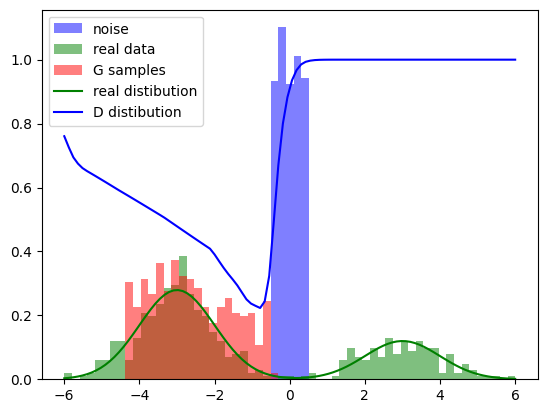

Epoch 14/20 (13s): G=0.922, Dr=0.632, Df=0.519


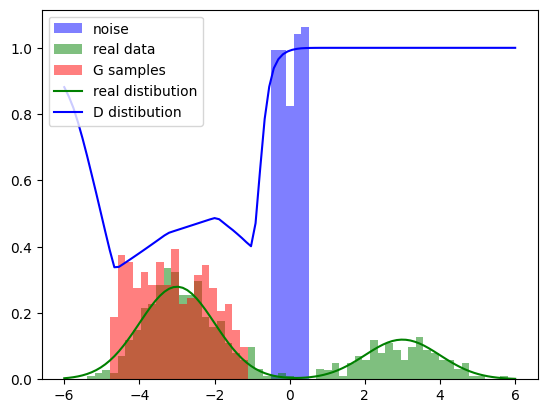

Epoch 15/20 (14s): G=0.909, Dr=0.605, Df=0.528


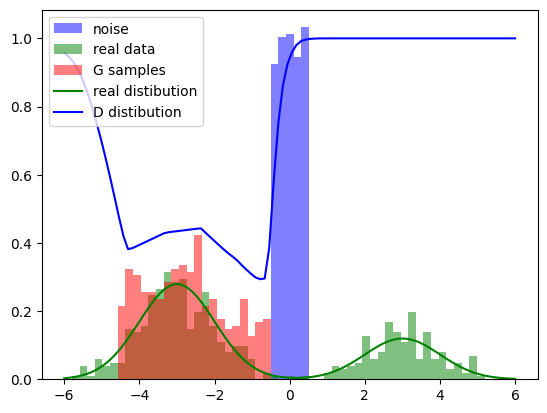

Epoch 16/20 (15s): G=0.915, Dr=0.614, Df=0.520


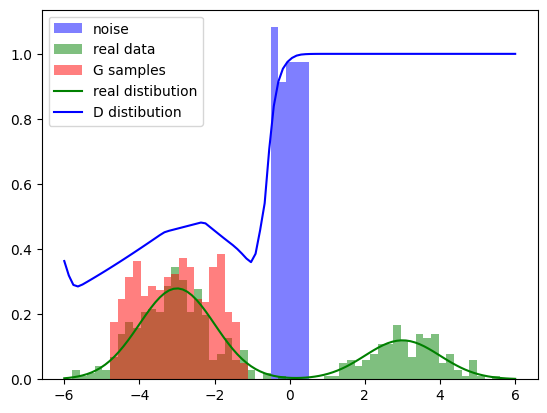

Epoch 17/20 (16s): G=0.902, Dr=0.615, Df=0.532


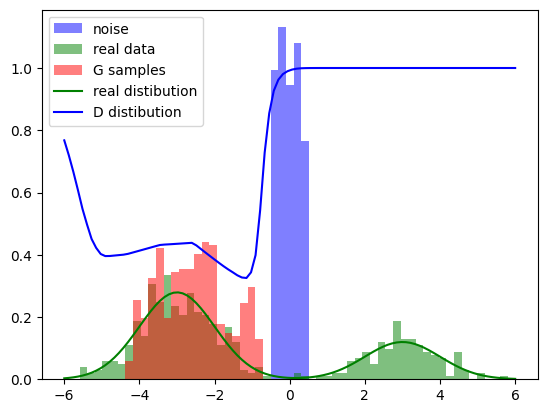

Epoch 18/20 (17s): G=0.921, Dr=0.615, Df=0.517


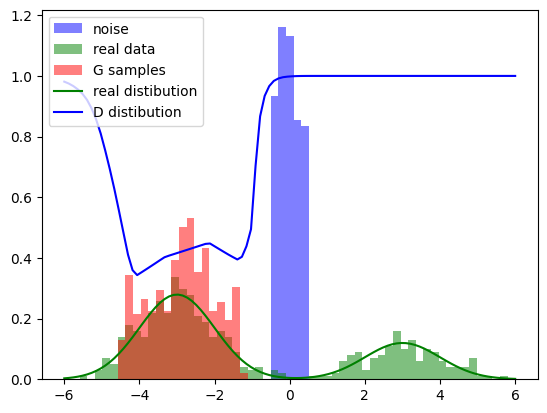

Epoch 19/20 (18s): G=0.915, Dr=0.609, Df=0.528


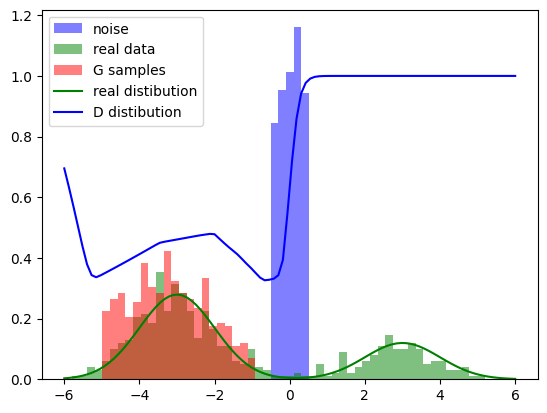

Epoch 20/20 (19s): G=0.905, Dr=0.624, Df=0.530


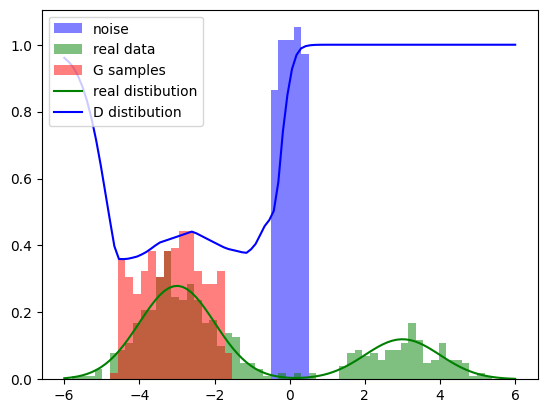

In [39]:
start = time()
for epoch in range(epochs):
    # break
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for i,batch in enumerate(range(batches)):
        lg_, (ldr_, ldf_) = gan.train_step()
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)

## Vanilla GAN on 2D data

In [40]:
def generate_2d_data(size, var=0.02):
    scale = 2
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1. / np.sqrt(2), 1. / np.sqrt(2)),
        (1. / np.sqrt(2), -1. / np.sqrt(2)),
        (-1. / np.sqrt(2), 1. / np.sqrt(2)),
        (-1. / np.sqrt(2), -1. / np.sqrt(2))
    ]

    centers = [(scale * x, scale * y) for x, y in centers]
    dataset = []

    for i in range(size):
        point = np.random.randn(2) * var
        center = centers[np.random.choice(np.arange(len(centers)))]
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)

    dataset = np.array(dataset, dtype='float32')
    dataset /= 1.414  # stdev

    return dataset

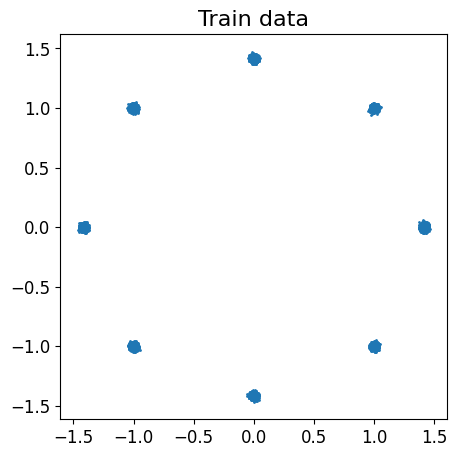

In [41]:
reset_seed()
COUNT = 20000

train_data = generate_2d_data(COUNT, var=0.02) # 0.02, 0.1, 0.4
visualize_2d_samples(train_data, "Train data")

Visualization functions

In [42]:
from seminar9_utils import make_inference, visualize_GAN_output

def plot_losses(losses, title):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title, fontsize=14)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

<img src="pics/gan_objective.jpg" width=800 height=800 />

In [43]:
from seminar9_utils import FullyConnectedMLP

`GAN` generator

In [44]:
class MLPGenerator(FullyConnectedMLP):

    def sample(self, n):
        z = torch.randn(size=(n, self.input_dim)).to(
            next(iter(self.parameters())))
        return self.forward(z)

`GAN` discriminator

In [45]:
class MLPDiscriminator(FullyConnectedMLP):

    def __init__(self, input_dim, hiddens, output_dim):
        super().__init__(input_dim, hiddens, output_dim)
        self._criterion = nn.BCELoss()

    def forward(self, z):
        x = super().forward(z)
        return F.sigmoid(x)

    def criterion(self, x, gt='fake'):
        assert gt in ['fake', 'real']
        tensor_gt = torch.zeros_like(x) if gt == 'fake' else torch.ones_like(x)
        return self._criterion(x, tensor_gt)

`GAN` training loop

In [46]:
def train_gan(
    generator, 
    discriminator, 
    train_loader,
    discriminator_steps, 
    batch_size,
    n_epochs,
    lr,
    not_saturating=False,
    visualize_steps=10):

    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0, 0.9))

    generator.train()
    discriminator.train()

    curr_iter = 0
    d_loss, g_loss = torch.zeros(1), torch.zeros(1)
    batch_loss_history = {'discriminator_losses': [], 'generator_losses': []}

    for epoch_i in tqdm(range(n_epochs)):
        for (batch_i, real_data) in enumerate(train_loader):
            curr_iter += 1
            real_data = real_data.to(DEVICE)

            # DISCRIMINATOR UPDATE
            with torch.no_grad():
                fake_data = generator.sample(real_data.shape[0])

            pred_real = discriminator(real_data)
            loss_real = discriminator.criterion(pred_real, 'real')
            pred_fake = discriminator(fake_data)
            loss_fake = discriminator.criterion(pred_fake, 'fake')

            discriminator_optimizer.zero_grad()
            d_loss = (loss_real + loss_fake) / 2.
            d_loss.backward()
            discriminator_optimizer.step()

            # GENERATOR UPDATE
            if curr_iter % discriminator_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                pred_fake = discriminator(fake_data).mean()

                if not_saturating:
                    g_loss = -discriminator.criterion(pred_fake, 'fake')
                else:
                    g_loss = discriminator.criterion(pred_fake, 'real')
                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history['generator_losses'].append(g_loss.data.cpu().numpy())
                batch_loss_history['discriminator_losses'].append(d_loss.data.cpu().numpy())

        if visualize_steps and epoch_i % visualize_steps == 0:
            print('Epoch {}'.format(epoch_i))
            samples, grid, discr_output, discr_grad_norms = make_inference(generator, discriminator)
            visualize_GAN_output(samples, train_data, grid, discr_output, discr_grad_norms)

    return batch_loss_history

`GAN` training

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0


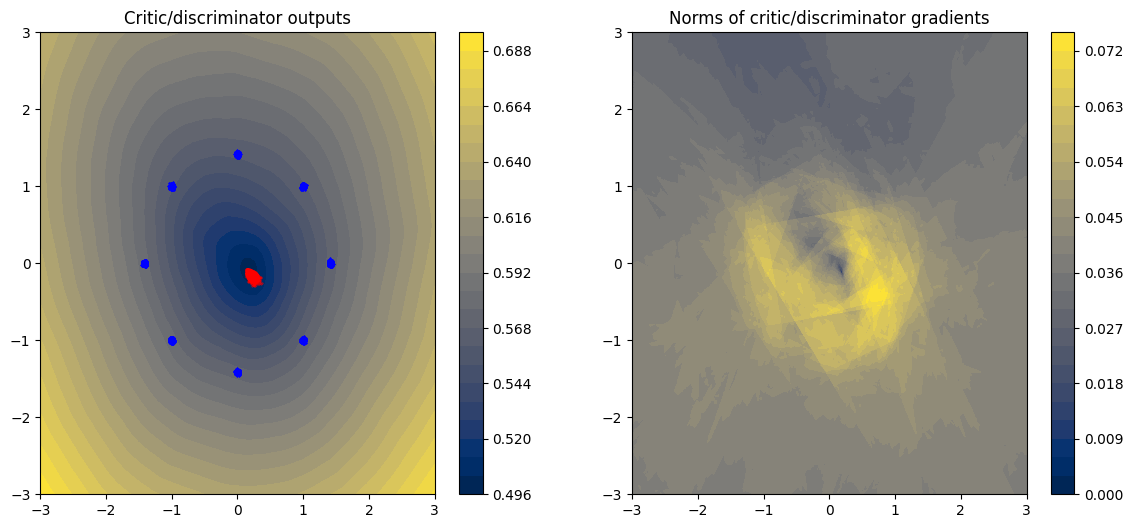

Epoch 20


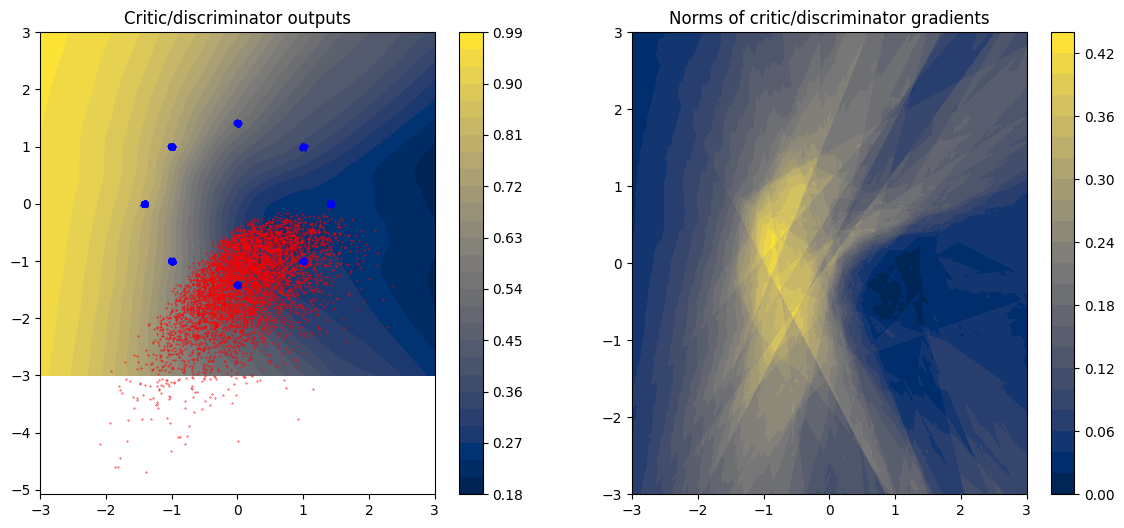

Epoch 40


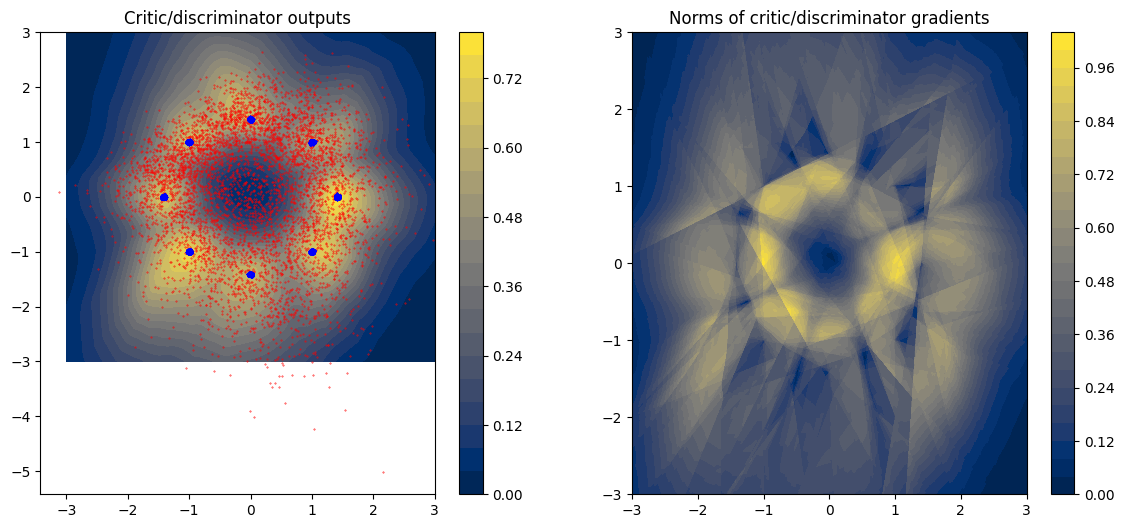

Epoch 60


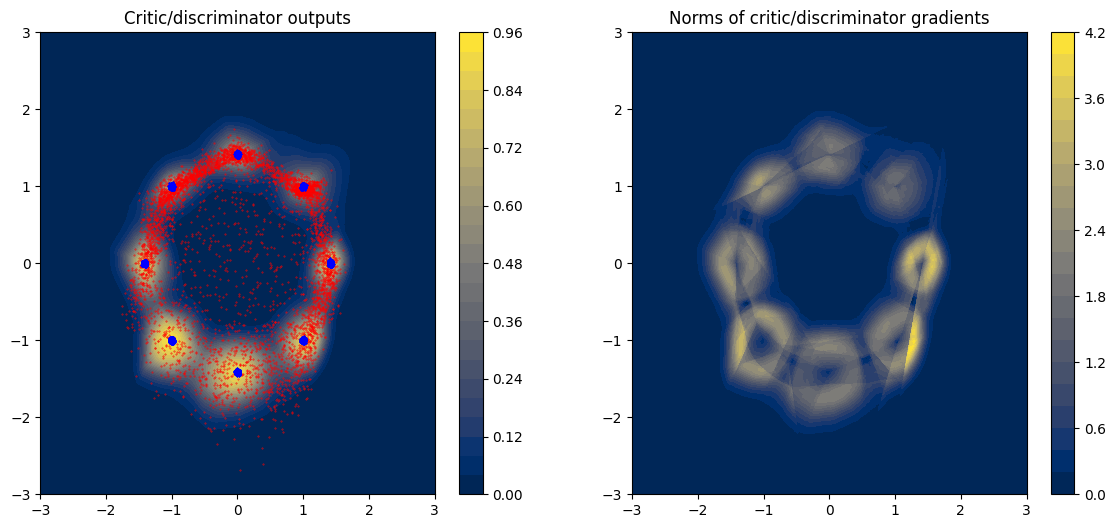

Epoch 80


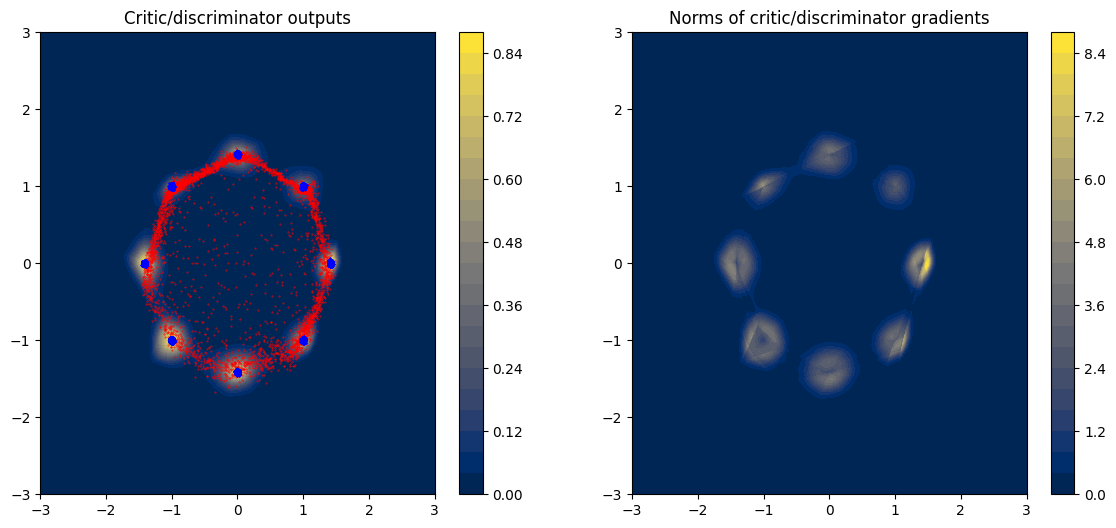

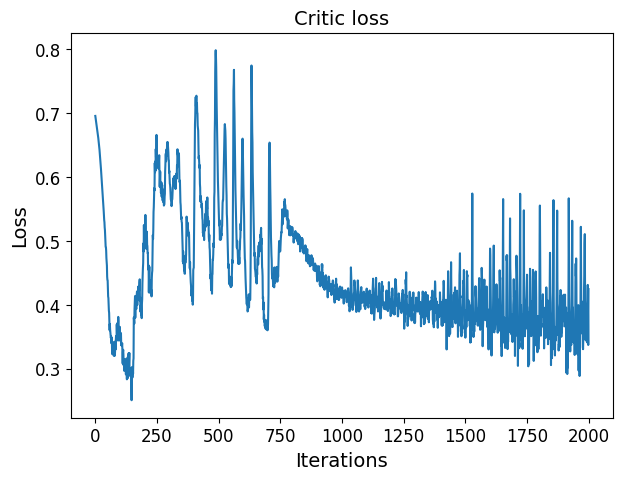

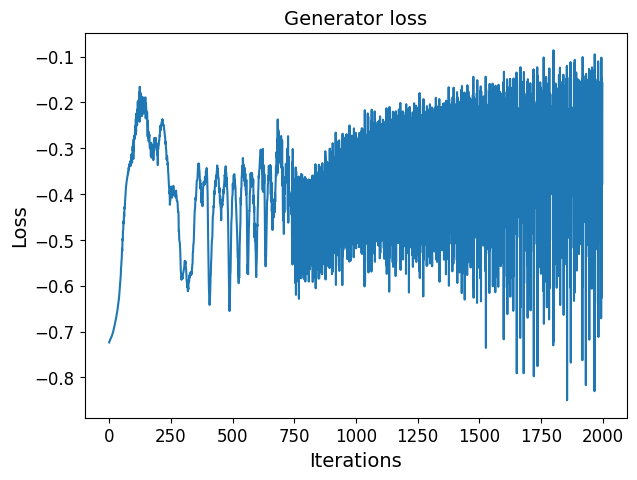

In [52]:
# CRITIC_STEPS = 5 => MODE COLLAPSE (SATURATING), NO LEARNING (NOT SATURATING)
# CRITIC_STEPS = 1 => NO MODE COLLAPSE 
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 1 # take 1/2
LR = 2e-4 # < 1e-2
NOT_SATURATING = True # take false

N_EPOCHS = 100 # change it if you want

train_loader = Tdata.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
discriminator = MLPDiscriminator(2, DISCR_HIDDENS, 1).to(DEVICE)

train_losses = train_gan(
    generator, 
    discriminator, 
    train_loader,
    discriminator_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    visualize_steps=20,
    not_saturating=NOT_SATURATING
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

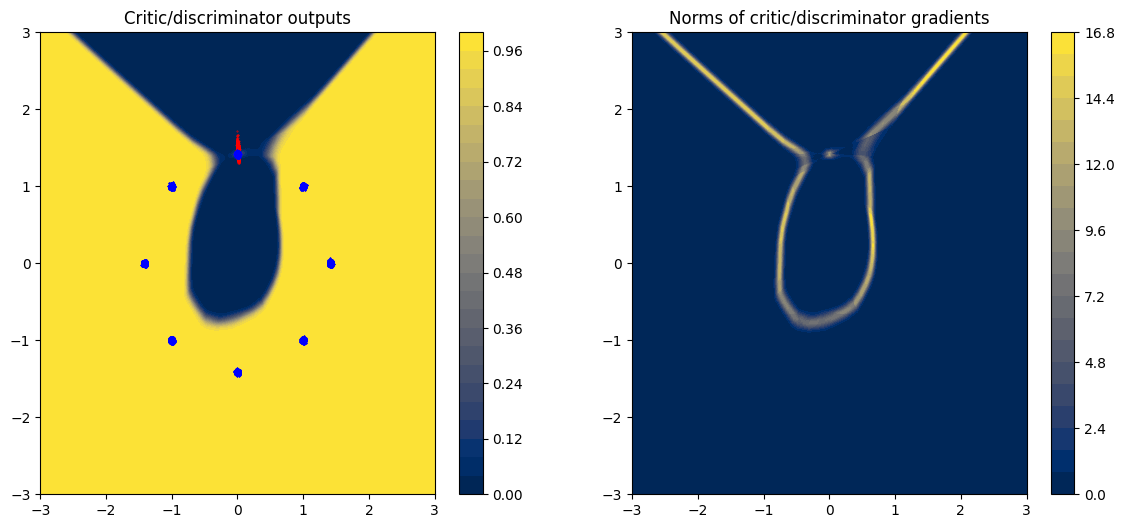

In [48]:
samples, grid, discr_output, discr_grad_norms = make_inference(generator, discriminator)
visualize_GAN_output(samples, train_data, grid, discr_output, discr_grad_norms)

# 1 - Wasserstein distance

## Discrete 1-Wasserstein distance

<img src="pics/WD.jpg" width=800 height=800 />

In [2]:
p = np.array([3,2,1,4])
pi = np.array([1,2,4,3])

p = p / p.sum()
pi = pi / pi.sum()

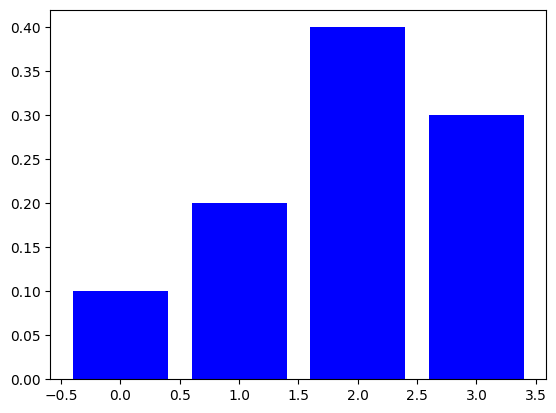

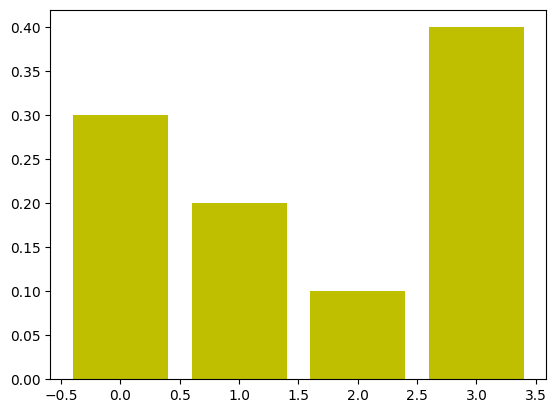

In [3]:
plt.bar(range(4), pi, color='b')
plt.show()
plt.bar(range(4), p, color='y')
plt.show()

In [4]:
transport_plan_example = pi.reshape(-1, 1) * p.reshape(1, -1)

In [5]:
transport_plan_example

array([[0.03, 0.02, 0.01, 0.04],
       [0.06, 0.04, 0.02, 0.08],
       [0.12, 0.08, 0.04, 0.16],
       [0.09, 0.06, 0.03, 0.12]])

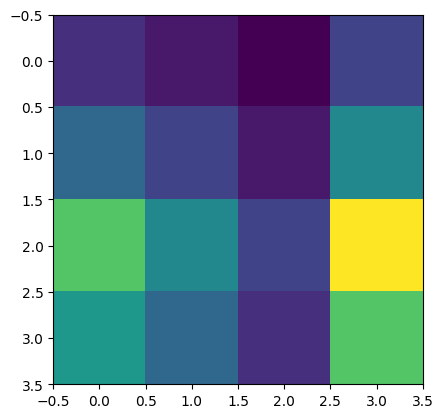

In [6]:
plt.imshow(transport_plan_example)
plt.show()

In [7]:
transport_plan_example.sum()

1.0

In [8]:
transport_plan_example.sum(axis=1)

array([0.1, 0.2, 0.4, 0.3])

In [9]:
pi

array([0.1, 0.2, 0.4, 0.3])

In [10]:
transport_plan_example.sum(axis=1)

array([0.1, 0.2, 0.4, 0.3])

In [11]:
p

array([0.3, 0.2, 0.1, 0.4])

In [12]:
cost = np.abs(np.arange(4).reshape(-1, 1) - np.arange(4).reshape(1, -1)).astype('float')

In [13]:
cost

array([[0., 1., 2., 3.],
       [1., 0., 1., 2.],
       [2., 1., 0., 1.],
       [3., 2., 1., 0.]])

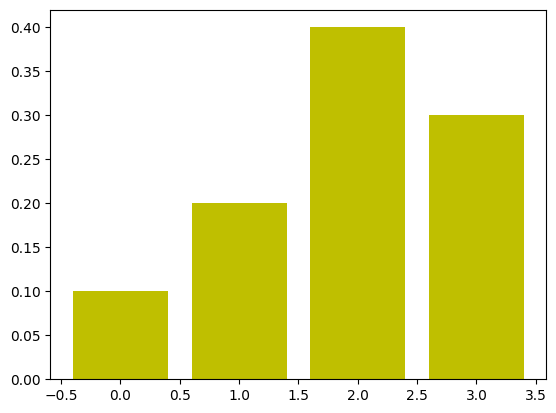

0 -> 0, how many: 0.030, cost: 0.000, total_cost: 0.000


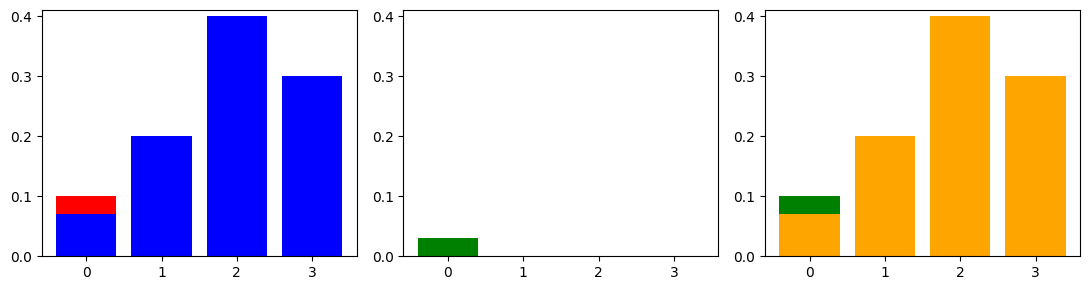

0 -> 1, how many: 0.020, cost: 0.020, total_cost: 0.020


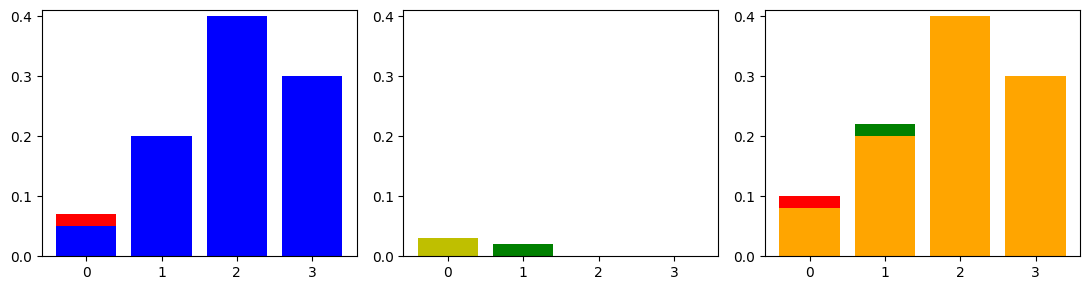

0 -> 2, how many: 0.010, cost: 0.020, total_cost: 0.040


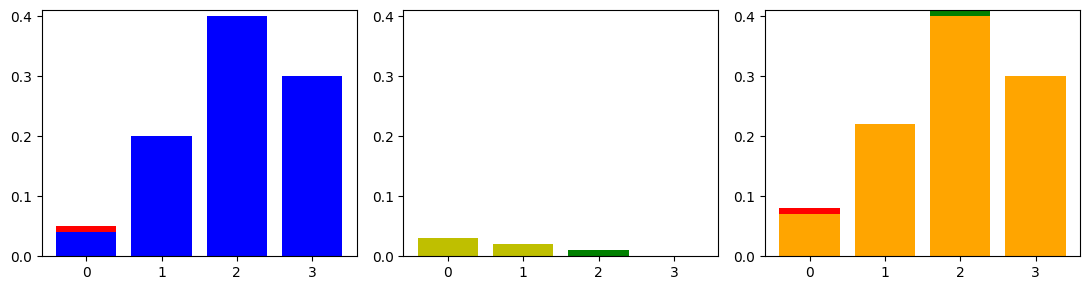

0 -> 3, how many: 0.040, cost: 0.120, total_cost: 0.160


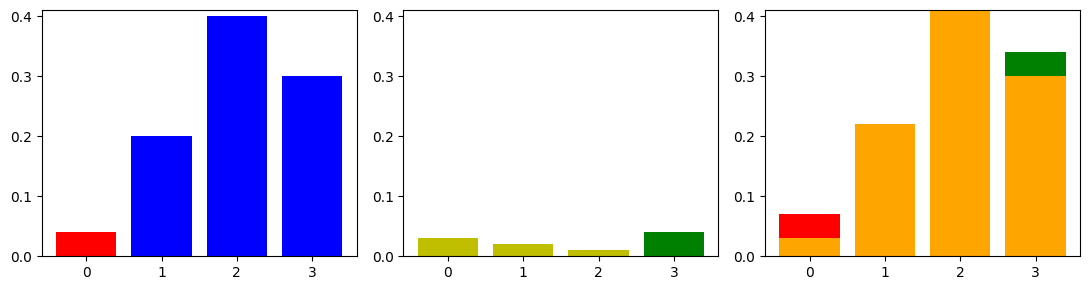

1 -> 0, how many: 0.060, cost: 0.060, total_cost: 0.220


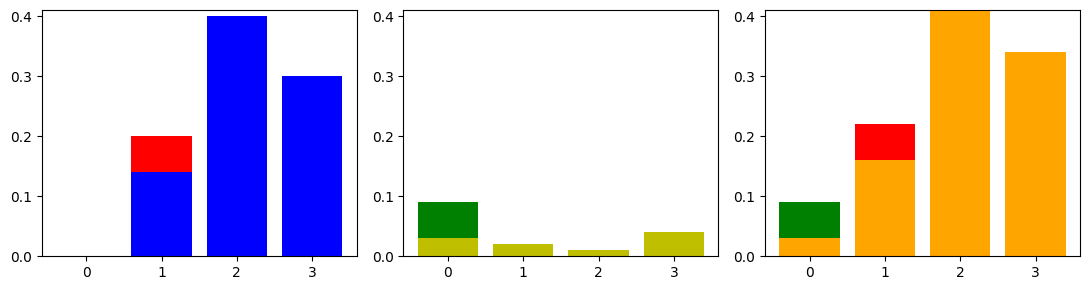

1 -> 1, how many: 0.040, cost: 0.000, total_cost: 0.220


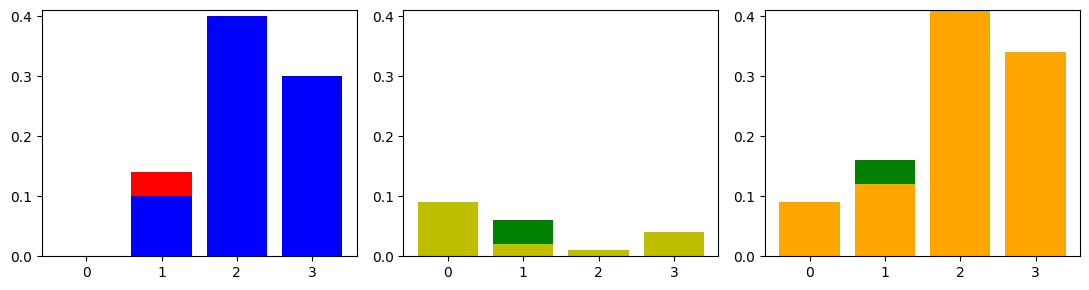

1 -> 2, how many: 0.020, cost: 0.020, total_cost: 0.240


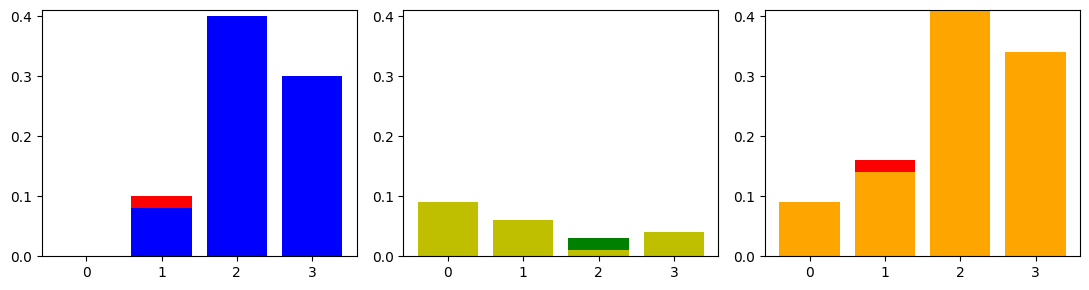

1 -> 3, how many: 0.080, cost: 0.160, total_cost: 0.400


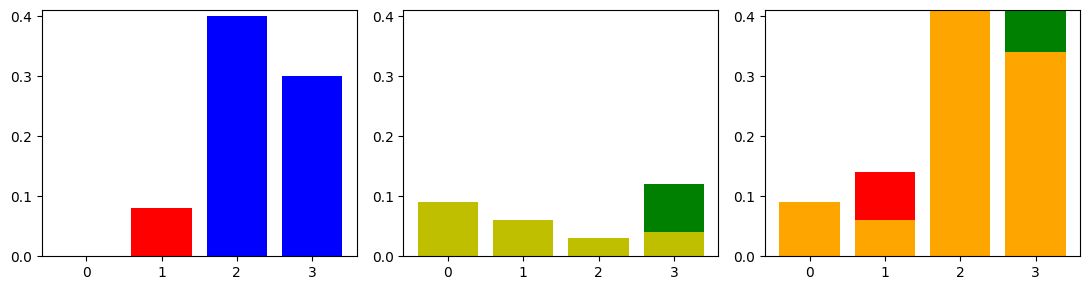

2 -> 0, how many: 0.120, cost: 0.240, total_cost: 0.640


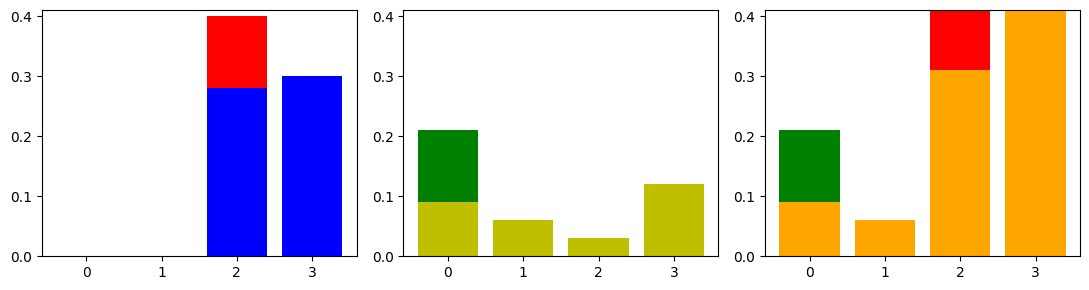

2 -> 1, how many: 0.080, cost: 0.080, total_cost: 0.720


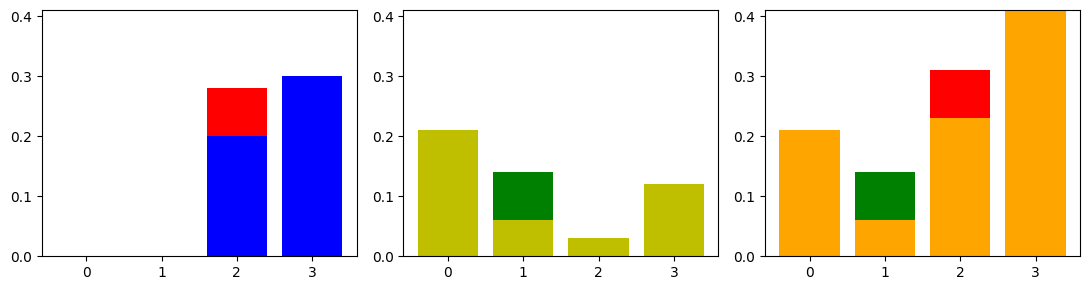

2 -> 2, how many: 0.040, cost: 0.000, total_cost: 0.720


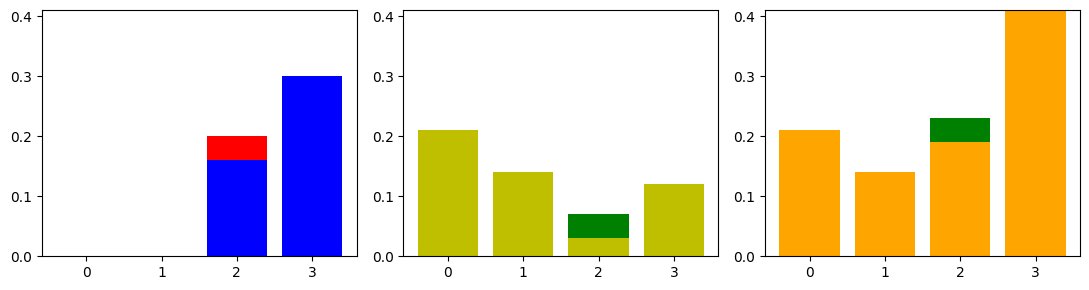

2 -> 3, how many: 0.160, cost: 0.160, total_cost: 0.880


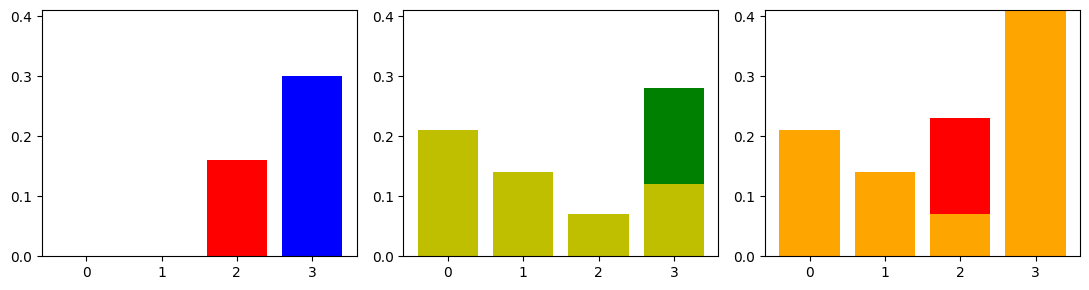

3 -> 0, how many: 0.090, cost: 0.270, total_cost: 1.150


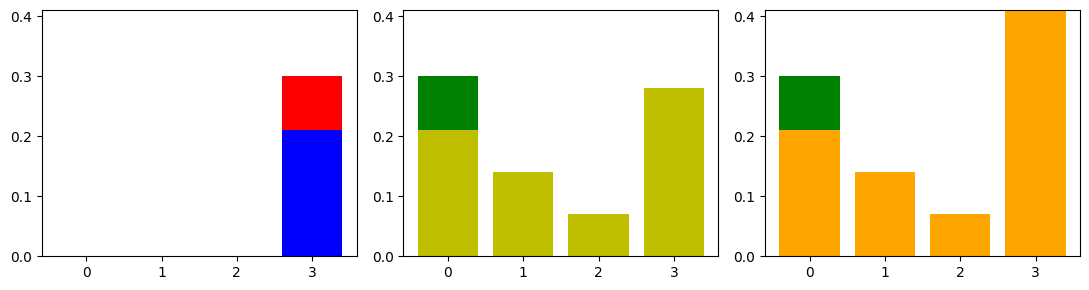

3 -> 1, how many: 0.060, cost: 0.120, total_cost: 1.270


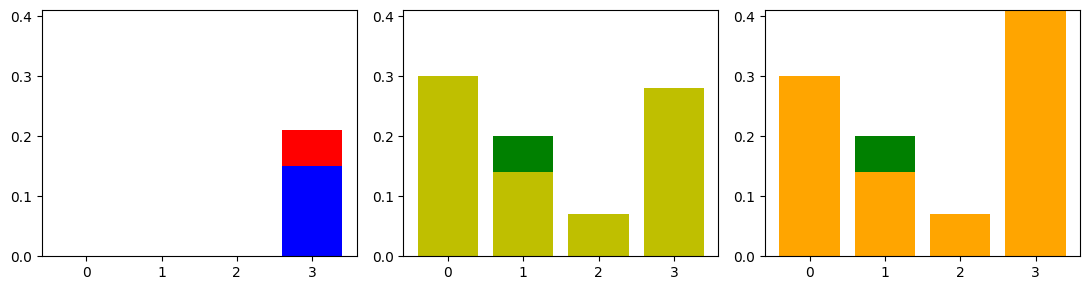

3 -> 2, how many: 0.030, cost: 0.030, total_cost: 1.300


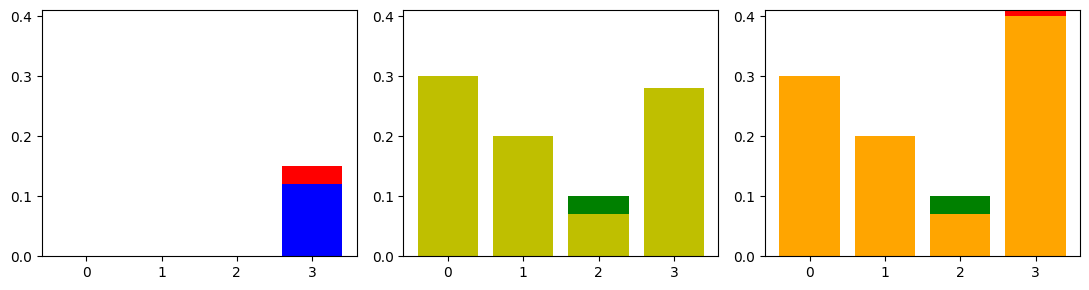

3 -> 3, how many: 0.120, cost: 0.000, total_cost: 1.300


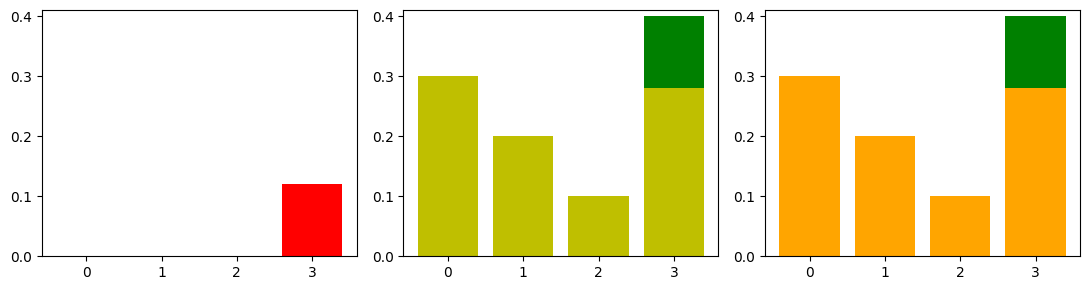

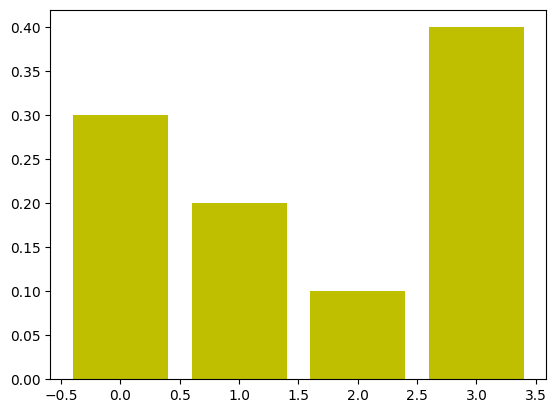

In [14]:
pi_reduction = np.zeros((17, 4))
p_building = np.zeros((17, 4))
pi_reduction[0] = pi.copy()

def draw_one_step(step):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))
    axs[0].bar(range(4), pi_reduction[step - 1], color='r')
    axs[0].bar(range(4), pi_reduction[step], color='b')
    axs[0].set_ylim(0, 0.41)
    axs[1].bar(range(4), p_building[step], color='g')
    axs[1].bar(range(4), p_building[step - 1], color='y')
    axs[1].set_ylim(0, 0.41)
    axs[2].bar(range(4), p_building[step - 1] + pi_reduction[step - 1], color='r')
    axs[2].bar(range(4), p_building[step] + pi_reduction[step], color='g')
    axs[2].bar(range(4), p_building[step - 1] + pi_reduction[step], color='orange')
    axs[2].set_ylim(0, 0.41)
    plt.tight_layout()
    plt.show()

plt.bar(range(4), pi, color='b')
plt.show()

step = 0
total_cost = 0.0
for i in range(4):
    for j in range(4):
        step += 1
        pi_reduction[step] = pi_reduction[step - 1].copy()
        pi_reduction[step][i] -= transport_plan_example[i, j]
        p_building[step] = p_building[step - 1].copy()
        p_building[step][j] += transport_plan_example[i, j]
        c = transport_plan_example[i, j] * cost[i, j]
        total_cost += c
        print('{} -> {}, how many: {:.3f}, cost: {:.3f}, total_cost: {:.3f}'.format(
            i,j, transport_plan_example[i, j], c, total_cost))
        draw_one_step(step)
        
plt.bar(range(4), p, color='y')
plt.show()

Package for discrete OT problems: [POT](https://pythonot.github.io/index.html)

In [15]:
transport_plan_optimal = ot.emd(pi, p, cost)
w_distance = ot.emd2(pi, p, cost)
print('w_distance: ', w_distance)

w_distance:  0.5


In [16]:
np.allclose(transport_plan_optimal.sum(axis=1), pi)

True

In [17]:
np.allclose(transport_plan_optimal.sum(axis=0), p)

True

In [18]:
pi

array([0.1, 0.2, 0.4, 0.3])

In [19]:
p

array([0.3, 0.2, 0.1, 0.4])

In [20]:
np.round(transport_plan_optimal, 5)

array([[0.1, 0. , 0. , 0. ],
       [0.2, 0. , 0. , 0. ],
       [0. , 0.2, 0.1, 0.1],
       [0. , 0. , 0. , 0.3]])

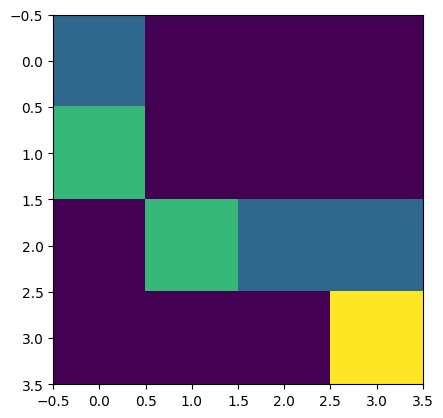

In [21]:
plt.imshow(transport_plan_optimal)
plt.show()

### Discrete optimal transport complexities

* original optimal transport problem : $O(n^3 \log(n))$

$$\gamma^* = \arg\min\limits_{\gamma \in \mathbb{R}^{n \times n}_{+}} \sum\limits_{i, j} \gamma_{i, j} \text{Cost}_{i, j}\\ \,\, \text{s.t. } \gamma 1 = \pi ; \gamma^T 1 = p$$

* (`*`) $\varepsilon$ - entropy regularized optimal transport problem: repeated iterations of Sinkhorn algorithm $O(n^2)$, convergence rate depends on $\varepsilon$

$$\gamma^*_{\varepsilon} = \arg\min\limits_{\gamma \in \mathbb{R}^{n \times n}_{+}} \sum\limits_{i, j} \gamma_{i, j} \text{Cost}_{i, j} + \varepsilon KL(\gamma | \pi \otimes p)\\ \,\, \text{s.t. } \gamma 1 = \pi ; \gamma^T 1 = p$$

Check the [video](https://www.youtube.com/watch?v=ecbbuGTj3DI) for the details.

### Continuous 1-Wasserstein distance